# Importing dependencies

The only dependecy we need is the awesome `python-chess` module. Besides that we import types from the `typing` module to help specify types of inputs and outputs to our functions

In [1]:
from typing import Tuple, List, Dict, Optional

import chess
import chess.pgn

# Computing the fraction of moves that were captures

Given a game, we want to compute the fraction of moves that were captures, and do that for each of the players.

In [2]:
def get_captures_fractions(game: chess.pgn.Game) -> Tuple[float, float]:
    board = game.board()
    if board.fen() != chess.STARTING_FEN:
        raise ValueError("Game must start from the initial position")

    num_moves = [0, 0]
    num_captures = [0, 0]
    for i, move in enumerate(game.mainline_moves()):
        player_idx = 1 if board.turn else 0
        num_moves[player_idx] += 1
        if board.is_capture(move):
            num_captures[player_idx] += 1
        board.push(move)
    return num_captures[0] / num_moves[0], num_captures[1] / num_moves[1]


# Computing fractions for all the games

We calculate the captures fractions from each game that has Elo headers, and for each game we emit two tuples:
(white, white elo, black fraction of captures)
(black, black elo, black fraction of captures)

In [3]:
%%time 

import pickle

data = []

# pgn_filepath = "/Volumes/t7/lichess_elite_2020-10.pgn"  
pgn_filepath = "/Volumes/t7/lichess_db_standard_rated_2020-10.pgn"
# pgn_filepath = "example2.pgn"


def time_control_str(base_minutes, increment):
    return "{}+{}".format(60*base_minutes, increment)
    
time_controls = [
    # blitz
    time_control_str(3, 0),
    time_control_str(3, 2),
    time_control_str(5, 0),
    time_control_str(5, 3),
    # rapid
    time_control_str(10, 0),
    time_control_str(10, 5),
    time_control_str(15, 10),
    # classical
    time_control_str(30, 0),
    time_control_str(30, 20),
]

limit = 2*10**6
num_games = 0
batch = 10**4

# run this to dump the data to the disk first
if False:
    with open(pgn_filepath) as pgn_file:
        while True:
            if num_games >= limit:
                break
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            time_control = game.headers.get('TimeControl')
            if time_control not in time_controls:
                continue
            elos = [game.headers.get('WhiteElo'), game.headers.get('BlackElo')]
            if any(elo is None or elo == '' for elo in elos):
                continue

            try:
                fractions = get_captures_fractions(game)
            except ZeroDivisionError:
                continue
            else:
                if num_games > 0 and (num_games % batch) == 0:
                    print(num_games // batch)
                    # dump to disk
                    outpath = "data/%d.p" % num_games
                    with open(outpath, "wb") as fp:
                        pickle.dump(data, fp)
                    data = []
                white_row = ("white", int(elos[0]), fractions[0])
                black_row = ("black", int(elos[1]), fractions[1])
                data.append(white_row)
                data.append(black_row)
                num_games += 1

        if data:
            # dump final chunk to disk
            outpath = "data/%d.p" % num_games
            with open(outpath, "wb") as fp:
                pickle.dump(data, fp)

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 27.9 µs


# Reading data from disk

In [4]:
import os
import pickle

games_data_dir = "games_data"

data = []
for filename in os.listdir(games_data_dir):
    if filename.endswith(".p"):
        filepath = os.path.join(games_data_dir, filename)
        with open(filepath, "rb") as fp:
            data.extend(pickle.load(fp))

print(len(data))

4000000


# Grouping the results by Elo

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

### Construct DataFrame

In [6]:
df = pd.DataFrame([(e[1], e[2]) for e in data], columns=['elo', 'captures'])
df.describe()

,elo,captures
count,4.000000e+06,4.000000e+06
mean,1.654515e+03,2.388933e-01
std,3.318969e+02,7.318482e-02
min,6.000000e+02,0.000000e+00
25%,1.419000e+03,1.964286e-01
50%,1.666000e+03,2.352941e-01
75%,1.895000e+03,2.800000e-01
max,3.126000e+03,9.166667e-01


### Drop rows with absolute value of Standard Score at least 3

In [7]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df.describe()

,elo,captures
count,3.918471e+06,3.918471e+06
mean,1.658475e+03,2.409878e-01
std,3.297103e+02,6.490911e-02
min,6.590000e+02,1.960784e-02
25%,1.424000e+03,2.000000e-01
50%,1.670000e+03,2.368421e-01
75%,1.897000e+03,2.800000e-01
max,2.650000e+03,4.583333e-01


### Drop rows with Elo less than 100

In [8]:
df = df[df.elo >= 1000]
df.describe()

,elo,captures
count,3.832296e+06,3.832296e+06
mean,1.675209e+03,2.405112e-01
std,3.135405e+02,6.446880e-02
min,1.000000e+03,1.960784e-02
25%,1.443000e+03,2.000000e-01
50%,1.680000e+03,2.363636e-01
75%,1.903000e+03,2.800000e-01
max,2.650000e+03,4.583333e-01


# Plotting

For plotting we use `matplotlib` so you should have it installed if you want to get a nice plot along the numerical data.

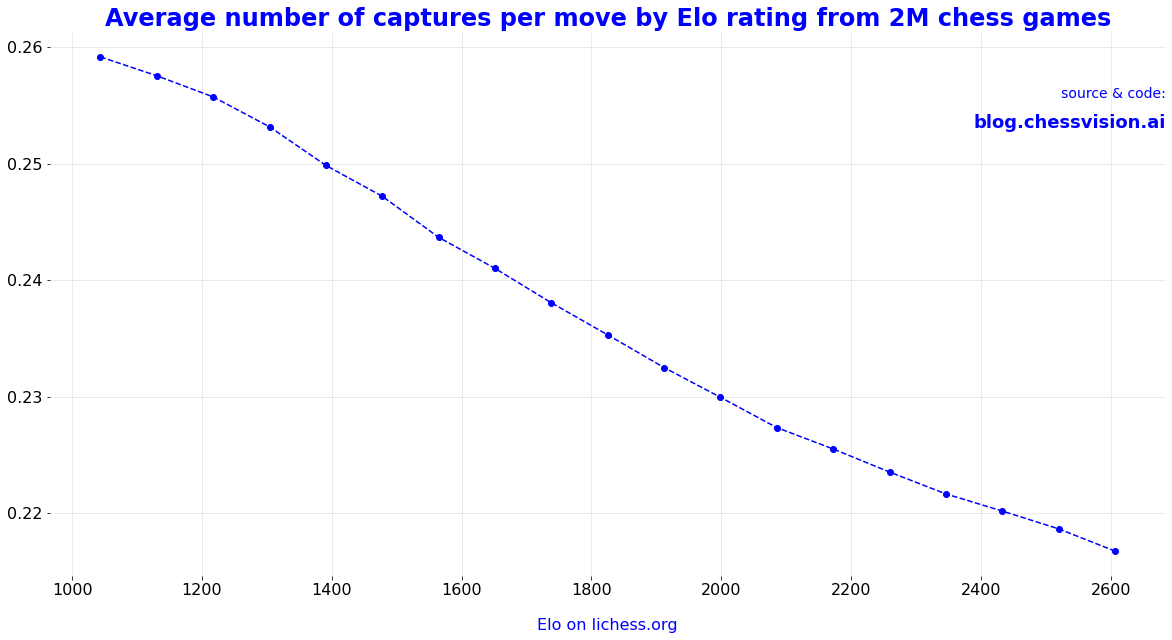

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.color'] = '#ccc'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(20, 10))   
ax.set_frame_on(False) 
    
# using https://stackoverflow.com/questions/47158443/pandas-plot-mean-values-within-bins-formatting-help-needed

min_elo = df.elo.min()
max_elo = df.elo.max()

bins = np.linspace(min_elo, max_elo, 20)
group = df.groupby(pd.cut(df.elo, bins))

plot_centers = (bins[:-1] + bins[1:]) / 2
plot_values = group.captures.mean()

plt.plot(plot_centers, plot_values, linestyle='--', marker='o', color='b')
    
ax.text(1, .9, "source & code:", 
        va='top', ha='right', color='b', fontsize=14, fontweight='normal', transform=ax.transAxes)
ax.text(1, .85, "blog.chessvision.ai", 
        va='top', ha='right', color='b', fontsize=18, fontweight='bold', transform=ax.transAxes)

# ax.set_ylabel('Captures\nper\nmove', fontsize=16, color='b', rotation=0, ha='left', labelpad=100)
ax.set_xlabel('Elo on lichess.org', fontsize=16, color='b', labelpad=20)

plt.title("Average number of captures per move by Elo rating from %dM chess games" % (len(data) // 2 // 10**6),
         fontdict={"fontsize": 24, "fontweight": "bold", "color": "b"})

plt.yticks(fontsize=16, color='black', fontweight='normal')
plt.xticks(fontsize=16, color='black', fontweight='normal')
plt.grid()
plt.show()
fig.savefig('plot.png', dpi=fig.dpi, edgecolor='none', bbox_inches='tight', pad_inches=0.5)